In [54]:
%matplotlib inline

In [74]:

import seaborn as sns
from ipywidgets import interact
import pandas as pd
import sqlite3
from sqlite3 import Error
import time


def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [75]:
# Create DB file

normalized_db = 'lightning_fire_normalized.db'
conn = create_connection(normalized_db, delete_db=True)

In [76]:
df = pd.read_csv("US_Lightning_Forest_Fires.csv")
df.head()

,Unnamed: 0,index,FIRE_YEAR,Fire_Date,DISCOVERY_TIME,STAT_CAUSE_DESCR,Days_to_extinguish_fire,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,FIPS_CODE,FIPS_NAME
0,0,1,2004,05-12-2004,845.0,Lightning,0.0,1530.0,0.25,A,38.933056,-120.404444,CA,61.0,Placer
1,1,3,2004,06-28-2004,1600.0,Lightning,5.0,1400.0,0.10,A,38.559167,-119.913333,CA,3.0,Alpine
2,2,4,2004,06-28-2004,1600.0,Lightning,5.0,1200.0,0.10,A,38.559167,-119.933056,CA,3.0,Alpine
3,3,5,2004,06-30-2004,1800.0,Lightning,1.0,1600.0,0.10,A,38.635278,-120.103611,CA,5.0,Amador
4,4,6,2004,07-01-2004,1800.0,Lightning,1.0,1400.0,0.10,A,38.688333,-120.153333,CA,17.0,El Dorado


In [77]:
df = df.drop(['index', 'STAT_CAUSE_DESCR', 'FIPS_CODE', 'FIPS_NAME'], axis=1)
df1 = df.iloc[: , 1:]
df1 = df1.dropna()
df1.head()

,FIRE_YEAR,Fire_Date,DISCOVERY_TIME,Days_to_extinguish_fire,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,2004,05-12-2004,845.0,0.0,1530.0,0.25,A,38.933056,-120.404444,CA
1,2004,06-28-2004,1600.0,5.0,1400.0,0.10,A,38.559167,-119.913333,CA
2,2004,06-28-2004,1600.0,5.0,1200.0,0.10,A,38.559167,-119.933056,CA
3,2004,06-30-2004,1800.0,1.0,1600.0,0.10,A,38.635278,-120.103611,CA
4,2004,07-01-2004,1800.0,1.0,1400.0,0.10,A,38.688333,-120.153333,CA


In [78]:
print(df1.shape)

(219593, 10)


In [79]:
df1.to_csv(path_or_buf="cleaned_data_lightning.csv")

In [80]:
header = []
for h in df1:
    header.append(h)
    
#print(columns)

In [82]:
# Create FireDate Table

create_region_sql = """CREATE TABLE IF NOT EXISTS[FireDate](
                        [FireDateID] INTEGER NOT NULL PRIMARY KEY,
                        [FireDate] TEXT NOT NULL,
                        [FireMonth] INTEGER NOT NULL,
                        [FireYear] INTEGER NOT NULL)"""
create_table(conn, create_region_sql)
fire_date = []

for val in df1['Fire_Date']:
    if val not in fire_date:
        date = val.split("-")
        fire_date.append((val, date[0], date[2])) 

fire_date.sort(key=lambda x: time.mktime(time.strptime(x[0],"%m-%d-%Y")))

fire_date_insert_vals = [(i+1, fire_date[i][0], fire_date[i][1], fire_date[i][2]) for i in range(len(fire_date))]
print(fire_date_insert_vals)

def insert_firedate(conn, values):
    sql = '''INSERT OR IGNORE INTO FireDate(FireDateID, FireDate, FireMonth, FireYear)
        VALUES(?, ?, ?, ?)'''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()
    return cur.lastrowid

insert_firedate(conn, fire_date_insert_vals)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [83]:
date = pd.read_sql_query("""SELECT * FROM FireDate""", conn)
date

,FireDateID,FireDate,FireMonth,FireYear
0,1,01-01-1992,1,1992
1,2,01-11-1992,1,1992
2,3,01-25-1992,1,1992
3,4,02-04-1992,2,1992
4,5,02-19-1992,2,1992
...,...,...,...,...
219588,219589,12-09-2015,12,2015
219589,219590,12-11-2015,12,2015
219590,219591,12-11-2015,12,2015
219591,219592,12-11-2015,12,2015


In [64]:
# Create fire_date dict

fire_date = {fire_date_insert_vals[i][1]: fire_date_insert_vals[i][0] for i in range(len(fire_date_insert_vals))}

In [65]:
print(fire_date)

{'01-01-1992': 1, '01-11-1992': 2, '01-25-1992': 3, '02-04-1992': 4, '02-19-1992': 5, '02-21-1992': 6, '02-23-1992': 7, '02-29-1992': 8, '03-01-1992': 9, '03-08-1992': 10, '03-09-1992': 11, '03-13-1992': 12, '03-19-1992': 13, '03-21-1992': 14, '03-22-1992': 15, '03-23-1992': 16, '03-24-1992': 17, '03-25-1992': 18, '03-26-1992': 19, '03-27-1992': 20, '03-28-1992': 21, '03-29-1992': 22, '03-30-1992': 23, '03-31-1992': 24, '04-01-1992': 25, '04-02-1992': 26, '04-04-1992': 27, '04-05-1992': 28, '04-08-1992': 29, '04-10-1992': 30, '04-11-1992': 31, '04-12-1992': 32, '04-13-1992': 33, '04-14-1992': 34, '04-15-1992': 35, '04-16-1992': 36, '04-17-1992': 37, '04-21-1992': 38, '04-22-1992': 39, '04-23-1992': 40, '04-24-1992': 41, '04-25-1992': 42, '04-26-1992': 43, '04-27-1992': 44, '04-28-1992': 45, '04-29-1992': 46, '04-30-1992': 47, '05-01-1992': 48, '05-02-1992': 49, '05-03-1992': 50, '05-04-1992': 51, '05-05-1992': 52, '05-06-1992': 53, '05-07-1992': 54, '05-08-1992': 55, '05-09-1992': 56, 

In [66]:
# Create FireState Table

create_firestate_sql = """CREATE TABLE IF NOT EXISTS[FireState](
                        [StateID] INTEGER NOT NULL PRIMARY KEY,
                        [State] TEXT NOT NULL)"""
create_table(conn, create_firestate_sql)

fire_state = []
for val in df1['STATE']:
    if val not in fire_state:
        fire_state.append(val)

fire_state.sort()
#print(fire_state)

fire_state_insert_vals = [(i+1, fire_state[i]) for i in range(len(fire_state))]

def insert_firestate(conn, values):
    sql = '''INSERT OR IGNORE INTO FireState(StateID, State)
        VALUES(?, ?)'''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()
    return cur.lastrowid

insert_firestate(conn, fire_state_insert_vals)

print(fire_state_insert_vals)

[(1, 'AK'), (2, 'AL'), (3, 'AR'), (4, 'AZ'), (5, 'CA'), (6, 'CO'), (7, 'DC'), (8, 'FL'), (9, 'GA'), (10, 'HI'), (11, 'IA'), (12, 'ID'), (13, 'IL'), (14, 'IN'), (15, 'KS'), (16, 'KY'), (17, 'LA'), (18, 'MA'), (19, 'MD'), (20, 'ME'), (21, 'MI'), (22, 'MN'), (23, 'MO'), (24, 'MS'), (25, 'MT'), (26, 'NC'), (27, 'ND'), (28, 'NE'), (29, 'NH'), (30, 'NJ'), (31, 'NM'), (32, 'NV'), (33, 'NY'), (34, 'OH'), (35, 'OK'), (36, 'OR'), (37, 'PA'), (38, 'PR'), (39, 'SC'), (40, 'SD'), (41, 'TN'), (42, 'TX'), (43, 'UT'), (44, 'VA'), (45, 'VT'), (46, 'WA'), (47, 'WI'), (48, 'WV'), (49, 'WY')]


In [67]:
state = pd.read_sql_query("""SELECT * FROM FireState""", conn)
state

,StateID,State
0,1,AK
1,2,AL
2,3,AR
3,4,AZ
4,5,CA
5,6,CO
6,7,DC
7,8,FL
8,9,GA
9,10,HI


In [68]:
# Create fire_state dict

fire_state = {fire_state_insert_vals[i][1]: fire_state_insert_vals[i][0] for i in range(len(fire_state_insert_vals))}
fire_state

{'AK': 1,
 'AL': 2,
 'AR': 3,
 'AZ': 4,
 'CA': 5,
 'CO': 6,
 'DC': 7,
 'FL': 8,
 'GA': 9,
 'HI': 10,
 'IA': 11,
 'ID': 12,
 'IL': 13,
 'IN': 14,
 'KS': 15,
 'KY': 16,
 'LA': 17,
 'MA': 18,
 'MD': 19,
 'ME': 20,
 'MI': 21,
 'MN': 22,
 'MO': 23,
 'MS': 24,
 'MT': 25,
 'NC': 26,
 'ND': 27,
 'NE': 28,
 'NH': 29,
 'NJ': 30,
 'NM': 31,
 'NV': 32,
 'NY': 33,
 'OH': 34,
 'OK': 35,
 'OR': 36,
 'PA': 37,
 'PR': 38,
 'SC': 39,
 'SD': 40,
 'TN': 41,
 'TX': 42,
 'UT': 43,
 'VA': 44,
 'VT': 45,
 'WA': 46,
 'WI': 47,
 'WV': 48,
 'WY': 49}

In [69]:
# Create FireDetails Table
create_details_sql = """CREATE TABLE IF NOT EXISTS[FireDetails](
                        [FireDetailsID] INTEGER NOT NULL PRIMARY KEY,
                        [FireDateID] INTEGER NOT NULL,
                        [DiscoveryTime] INTEGER NOT NULL,
                        [DaysToExt] INTEGER NOT NULL,
                        [ContTime] INTEGER NOT NULL,
                        [FireSize] REAL NOT NULL,
                        [FireClass] TEXT NOT NULL,
                        [Lattitude] TEXT NOT NULL,
                        [Longitude] TEXT NOT NULL,
                        [StateID] INTEGER NOT NULL,
                        FOREIGN KEY(FireDateID) REFERENCES FireDate(FireDateID),
                        FOREIGN KEY(StateID) REFERENCES FireState(StateID))"""
#import pdb
#pdb.set_trace()
create_table(conn, create_details_sql)

fire_details = []
with open("cleaned_data_lightning.csv", 'r') as db_file:
    for index, line in enumerate(db_file):
        if not line.strip() or index == 0:
            continue

        columns = line.split(',')
        days_to_ext = int(columns[4].split('.')[0])
        cont_time = int(columns[5].split('.')[0])
        fire_size = float(columns[6])
        fire_details.append((index, fire_date[columns[2]], int(columns[3].split('.')[0]), 
                             days_to_ext, cont_time, fire_size, columns[7], columns[8], columns[9],
                             fire_state[columns[10].rstrip()] ))

        
#fire_details = sorted(fire_details, key=lambda a : a[0] + ' ' + a[1])
fire_state_vals = []
for i in fire_details:
    fire_state_vals.append(i[9])
    

def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)
        
    return unique_list

#fire_uni = unique(fire_state_vals)

def insert_firedet(conn, values):
    sql = ''' INSERT OR IGNORE INTO FireDetails(FireDetailsID, FireDateID, DiscoveryTime, DaysToExt,
            ContTime, FireSize, FireClass, Lattitude, Longitude, StateID)
              VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()
    return cur.lastrowid

insert_firedet(conn, fire_details)

In [70]:
fire_details = pd.read_sql_query("""SELECT * FROM FireDetails""", conn)
fire_details

,FireDetailsID,FireDateID,DiscoveryTime,DaysToExt,ContTime,FireSize,FireClass,Lattitude,Longitude,StateID
0,1,2869,845,0,1530,0.25,A,38.93305556,-120.40444444,5
1,2,2916,1600,5,1400,0.10,A,38.55916667,-119.91333333,5
2,3,2916,1600,5,1200,0.10,A,38.55916667,-119.93305556,5
3,4,2918,1800,1,1600,0.10,A,38.63527778,-120.10361111,5
4,5,2919,1800,1,1400,0.10,A,38.68833333,-120.15333333,5
...,...,...,...,...,...,...,...,...,...,...
219588,219589,5626,2007,1,205,0.10,A,40.9885,-120.846667,5
219589,219590,4501,1444,1,1351,81.00,C,41.508867,-120.819167,5
219590,219591,5878,1204,0,1935,0.50,B,39.655817,-121.234567,5
219591,219592,5837,1752,0,2014,0.05,A,40.443000000000005,-120.664433,5


In [71]:
cur = conn.cursor()

cur.execute("""SELECT FireDate FROM FireDate ORDER BY FireDateID ASC LIMIT 1;""")
rows = cur.fetchall()
first_fire_date = rows[0][0]
cur.execute("""SELECT FireDate FROM FireDate ORDER BY FireDateID DESC LIMIT 1;""")
rows = cur.fetchall()
last_fire_date = rows[0][0]


from datetime import datetime
# Do last - first to get no of days
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m-%d-%Y")
    d2 = datetime.strptime(d2, "%m-%d-%Y")
    return abs((d2 - d1).days)

days_between(first_fire_date, last_fire_date)

8760

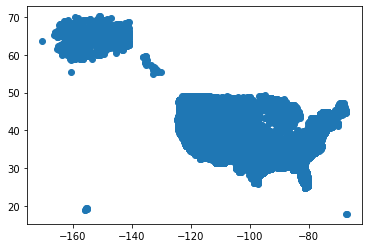

In [72]:
data = pd.read_csv("cleaned_data_lightning.csv")

import matplotlib.pyplot as plt
plt.scatter(x=df['LONGITUDE'], y=df['LATITUDE'])
plt.show()